In [1]:
%load_ext autoreload
%autoreload 2

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../ipa/src/')
import preprocessing_utils as pre
import localization_utils as loc
import detection_utils as det
import nd2
import correction_utils as cor
import stackview
from glob import glob
from tqdm import tqdm
import seaborn as sns
from sklearn import linear_model

# Multiple movies

In [65]:
df_comb = []
for path in tqdm(glob('/tungstenfs/scratch/ggiorget/nessim/2_color_imaging/localization_precision_estimation/runs/20240502_beads/*.csv')):
    df_temp = pd.read_csv(path)
    df_temp['run'] = path.split('/')[-1].split('.')[0]
    df_comb.append(df_temp)

df_comb = pd.concat(df_comb)

100%|██████████| 21/21 [00:00<00:00, 42.40it/s]


In [66]:
df_comb

,Unnamed: 0,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,channel,dx,dy,dz,run
0,0,87.236711,61.547071,2.259126,0.027124,0.030754,0.027302,0.0,1.0,0.008370,0.030672,0.067487,detections_20240430_beads_100ms_7%laser_nd_016
1,5,76.689899,90.301772,2.422309,0.032532,0.031799,0.029468,0.0,1.0,0.143482,-0.116881,0.050829,detections_20240430_beads_100ms_7%laser_nd_016
2,8,69.854417,85.723076,2.293320,0.035049,0.036259,0.036859,0.0,1.0,0.013954,0.020565,0.061180,detections_20240430_beads_100ms_7%laser_nd_016
3,12,126.220329,94.398456,1.869271,0.041661,0.043895,0.035808,0.0,1.0,0.041389,-0.009832,0.067310,detections_20240430_beads_100ms_7%laser_nd_016
4,13,77.639671,39.923842,1.753957,0.035241,0.034333,0.030798,0.0,1.0,0.006641,0.037780,0.045130,detections_20240430_beads_100ms_7%laser_nd_016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,817,81.336240,106.638308,2.493519,0.040436,0.045391,0.050647,0.0,1.0,0.013754,-0.013074,0.059201,detections_20240430_beads_100ms_7%laser_nd_004
578,819,114.655335,89.244749,2.428541,0.041065,0.049445,0.038282,0.0,1.0,0.012551,0.030050,0.050899,detections_20240430_beads_100ms_7%laser_nd_004
579,821,72.703062,68.329863,1.794147,0.047307,0.058581,0.041632,0.0,1.0,0.021896,0.008512,0.013854,detections_20240430_beads_100ms_7%laser_nd_004
580,822,118.242726,59.148375,2.234043,0.039556,0.041075,0.040614,0.0,1.0,0.021463,0.023578,0.026292,detections_20240430_beads_100ms_7%laser_nd_004


In [67]:
df_drop=df_comb[np.abs(df_comb["dx"].values)<0.12]
df_drop=df_drop[np.abs(df_drop["dy"].values)<0.12]
df_drop=df_drop[np.abs(df_drop["dz"].values)<0.2]

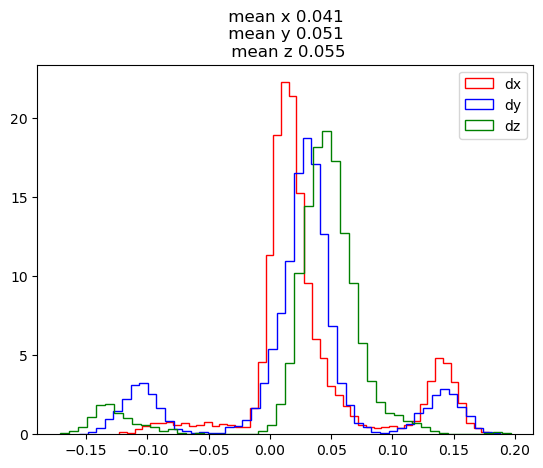

In [68]:
plt.hist(df_comb["dx"],histtype='step',color='r',bins=50,density=True,label='dx')
plt.hist(df_comb["dy"],histtype='step',color='b',bins=50,density=True,label='dy')
plt.hist(df_comb["dz"],histtype='step',color='g',bins=50,density=True,label='dz')
plt.title(f' mean x {np.mean(np.sqrt(df_comb["dx"].values**2)):,.3f} \n mean y {np.mean(np.sqrt(df_comb["dy"].values**2)):,.3f} \n mean z {np.mean(np.sqrt(df_comb["dz"].values**2)):,.3f}')
plt.legend()
plt.show()

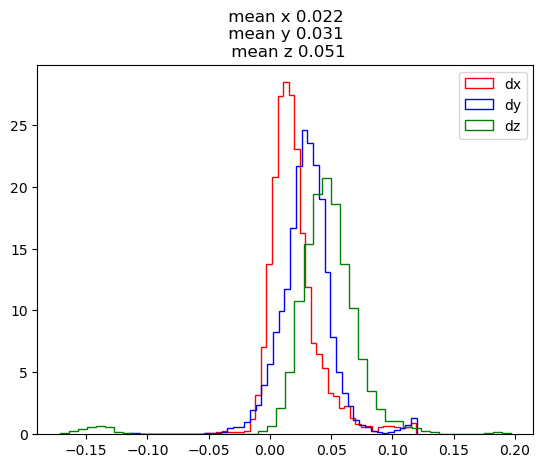

In [69]:
plt.hist(df_drop["dx"],histtype='step',color='r',bins=50,density=True,label='dx')
plt.hist(df_drop["dy"],histtype='step',color='b',bins=50,density=True,label='dy')
plt.hist(df_drop["dz"],histtype='step',color='g',bins=50,density=True,label='dz')
plt.title(f' mean x {np.mean(np.sqrt(df_drop["dx"].values**2)):,.3f} \n mean y {np.mean(np.sqrt(df_drop["dy"].values**2)):,.3f} \n mean z {np.mean(np.sqrt(df_drop["dz"].values**2)):,.3f}')
plt.legend()
plt.show()

/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

Text(0.5, 1.0, 'dx colored by movie')

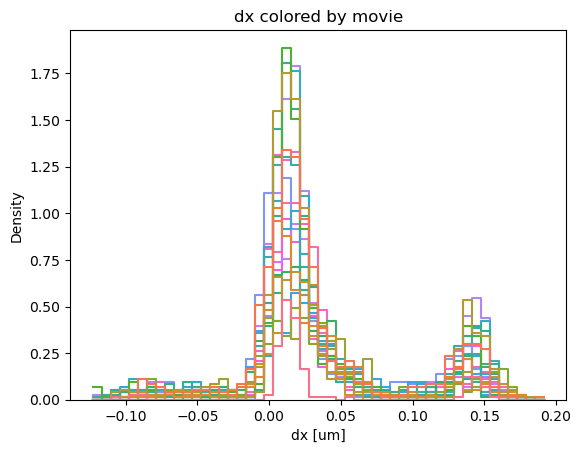

In [70]:
sns.histplot(data= df_comb,x='dx',element='step',fill=False,hue='run',bins=50,stat='density',label='dx',legend=False)
plt.xlabel('dx [um]')
plt.title('dx colored by movie')

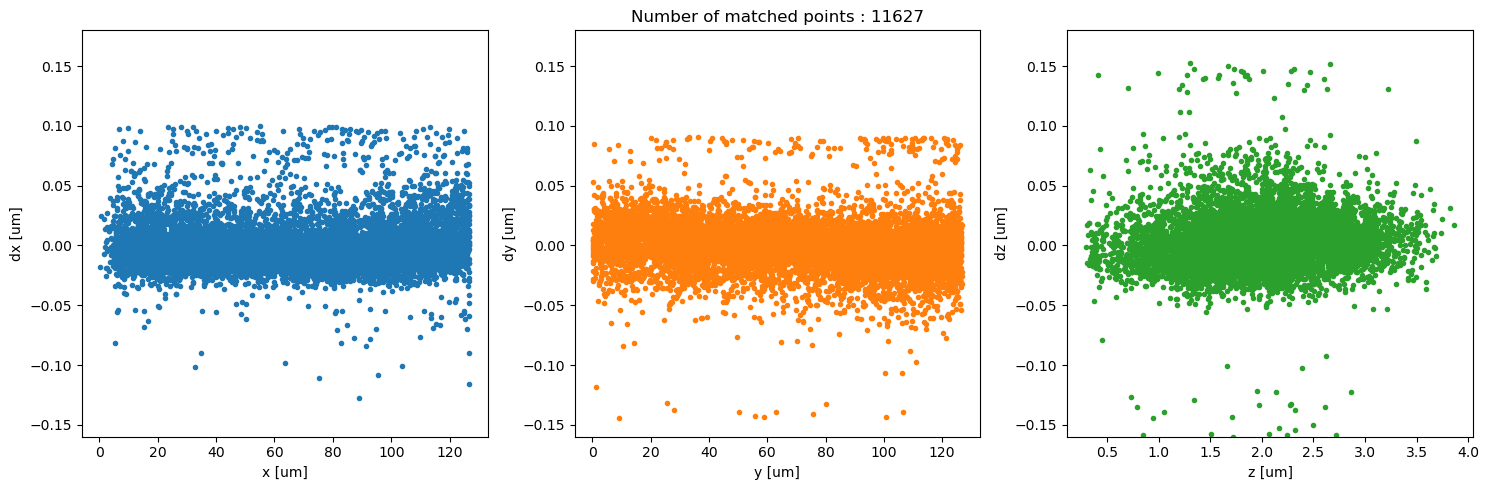

In [99]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(df_drop['x'],df_drop['dx'],'.')
ax[0].set_xlabel('x [um]')
ax[0].set_ylabel('dx [um]')

ax[1].plot(df_drop['y'],df_drop['dy'],'.',color='tab:orange')
ax[1].set_xlabel('y [um]')
ax[1].set_ylabel('dy [um]')
ax[2].plot(df_drop['z'],df_drop['dz'],'.',color='tab:green')
ax[2].set_xlabel('z [um]')
ax[2].set_ylabel('dz [um]')

ax[1].set_title(f'Number of matched points : {len(df_comb)}')

for a in ax:
    a.set_ylim(-0.16,0.18)

plt.tight_layout()
plt.show()

# for all movies

In [100]:
df_drop=df_comb[np.abs(df_comb["dx"].values)<0.12]
df_drop=df_drop[np.abs(df_drop["dy"].values)<0.12]
df_drop=df_drop[np.abs(df_drop["dz"].values)<0.2]

In [102]:
df_drop['dx']=df_drop['dx'].values-np.mean(df_drop['dx'].values)
fit=np.polyfit(df_drop['x'].values,df_drop['dx'].values,1)
df_drop['dx']=df_drop['dx'].values-fit[0]*df_drop['x'].values-fit[1]
df_drop['dy']=df_drop['dy'].values-np.mean(df_drop['dy'].values)
fit=np.polyfit(df_drop['y'].values,df_drop['dy'].values,1)
df_drop['dy']=df_drop['dy'].values-fit[0]*df_drop['y'].values-fit[1]
df_drop['dz']=df_drop['dz'].values-np.mean(df_drop['dz'].values)
fit=np.polyfit(df_drop['z'].values,df_drop['dz'].values,1)
df_drop['dz']=df_drop['dz'].values-fit[0]*df_drop['z'].values-fit[1]


In [124]:
reference = df_drop[['x','y','z']].values.T
moving = df_drop[['x','y','z']].values.T + df_drop[['dx','dy','dz']].values.T

R, t = cor.calculate_rototranslation_3D(reference.T,moving.T)

In [142]:
t

array([[ 0.0021868 ],
       [-0.00220332],
       [ 0.00194107]])

In [125]:
moving_cor = np.dot(R,moving)+t
dx,dy,dz = reference - moving_cor

In [143]:
t

array([[ 0.0021868 ],
       [-0.00220332],
       [ 0.00194107]])

[ 1.4321722e-06 -9.5484830e-05]


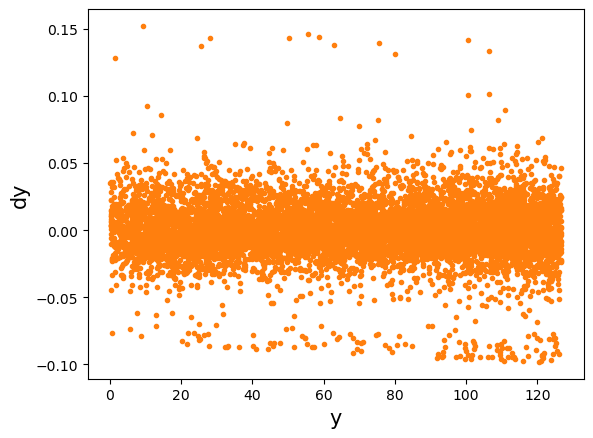

In [127]:
plt.plot(reference.T[:,1],dy,'.',color='tab:orange')
fit=np.polyfit(reference.T[:,1],dy,1)
plt.xlabel("y",fontsize=15)
plt.ylabel("dy",fontsize=15)
print(fit)

[-4.99453567e-22  1.98521797e-19]


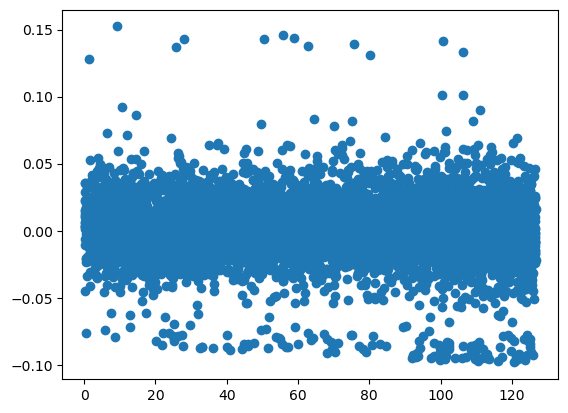

In [128]:
dy_test=dy-fit[0]*reference.T[:,1]-fit[1]
plt.plot(reference.T[:,1],dy_test,"o")
fit=np.polyfit(reference.T[:,1],dy_test,1)
print(fit)
plt.show()

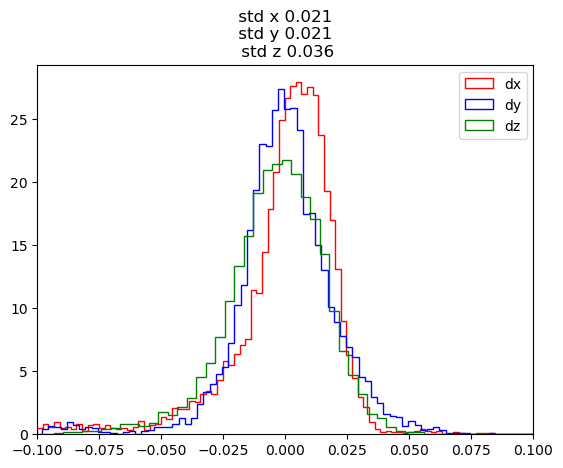

In [133]:
nbins=100
plt.hist(dx,histtype='step',color='r',bins=nbins,label='dx',density=True)
plt.hist(dy,histtype='step',color='b',bins=nbins,label='dy',density=True)
plt.hist(dz,histtype='step',color='g',bins=nbins,label='dz',density=True)
#plt.yscale("log")
#plt.xscale("log")
plt.title(f' std x {np.std(df_drop["dx"]):,.3f} \n std y {np.std(df_drop["dy"].values):,.3f} \n std z {np.std(df_drop["dz"].values):,.3f}')
plt.legend()
plt.xlim(-0.1,0.1)
plt.show()

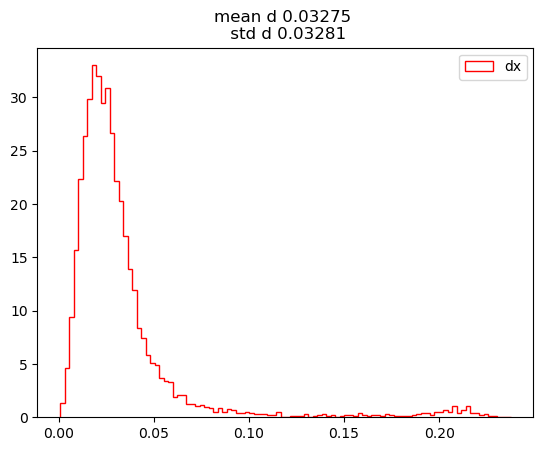

In [140]:
nbins=100
plt.hist(np.sqrt(dx**2+dy**2+dz**2),histtype='step',color='r',bins=nbins,label='dx',density=True)
#plt.yscale("log")
#plt.xscale("log")
plt.title(f'mean d {np.mean(np.sqrt(dx**2+dy**2+dz**2)):,.5f} \n std d {np.std(np.sqrt(dx**2+dy**2+dz**2)):,.5f}')
plt.legend()
#plt.xlim(-0.1,0.1)
plt.show()

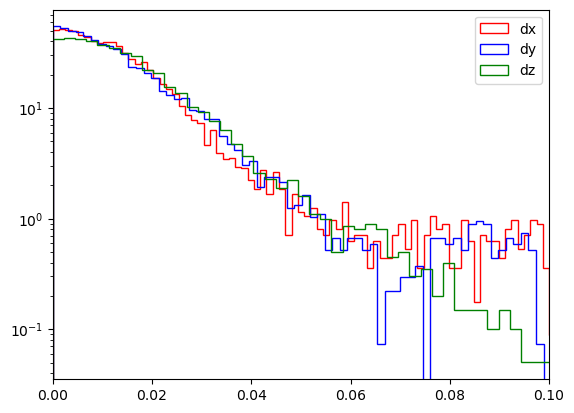

In [129]:
nbins=100
plt.hist(np.sqrt(dx**2),histtype='step',color='r',bins=nbins,label='dx',density=True)
plt.hist(np.sqrt(dy**2),histtype='step',color='b',bins=nbins,label='dy',density=True)
plt.hist(np.sqrt(dz**2),histtype='step',color='g',bins=nbins,label='dz',density=True)
plt.yscale("log")
#plt.xscale("log")
#plt.title(f' std x {np.std(df_drop["dx"]):,.3f} \n std y {np.std(df_drop["dy"].values):,.3f} \n std z {np.std(df_drop["dz"].values):,.3f}')
plt.legend()
plt.xlim(0.,0.1)
plt.show()

In [135]:
print(np.mean(np.sqrt(dx**2)),np.mean(np.sqrt(dy**2)),np.mean(np.sqrt(dz**2)))

0.014674786006797298 0.014598644560128844 0.019430266913154078


Text(0, 0.5, 'dy')

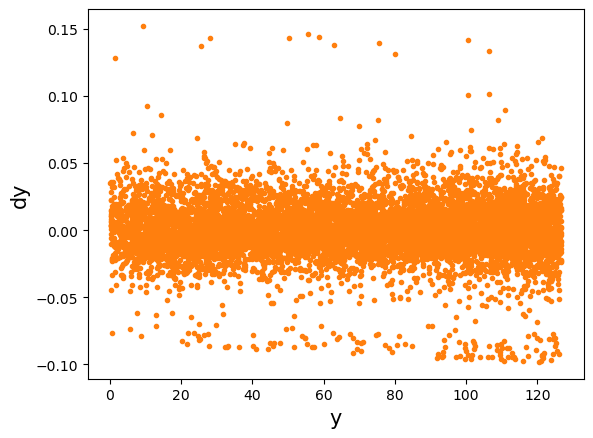

In [136]:
plt.plot(reference.T[:,1],dy,'.',color='tab:orange')
plt.xlabel("y",fontsize=15)
plt.ylabel("dy",fontsize=15)
